# Convolutional Neural Network (CNN) to classify handwritten digits using the MNIST dataset

Dennis Riungu Muticia - 101174617  - [GitHub](https://github.com/denpalrius/AI-Machine-Learning-Practice/blob/main/mlp/cnn_mnist.ipynb)

Matthias Otoo - 101145014 -  [Github](https://github.com/TitoLanna/CNN-Implementation-for-MNIST-Digit-Recognition.git)

In [102]:
from ucimlrepo import fetch_ucirepo

import torch
from torch.utils.data import DataLoader, TensorDataset

from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from datetime import datetime

# Load the dataset

In [40]:
handwritten_digits = fetch_ucirepo(id=80)

X = handwritten_digits.data.features.to_numpy()
y = handwritten_digits.data.targets.to_numpy()

Visualise the first 5 data items

In [41]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0


Visualise 5 digits from the dataset

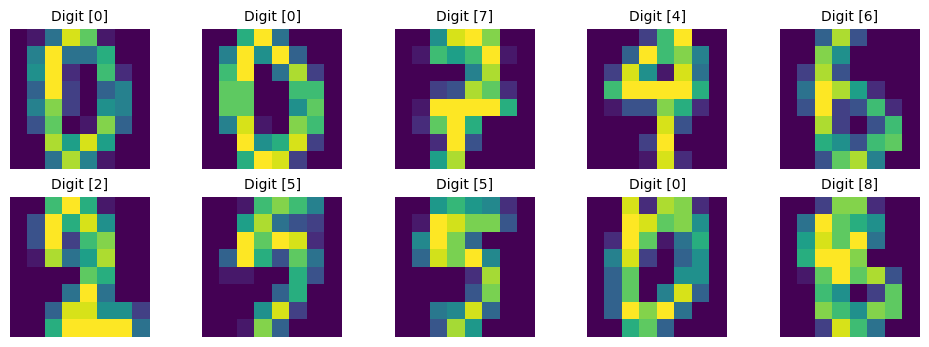

In [42]:
plt.figure(figsize=(12,4))
for index, (image, label) in enumerate(zip(X[0:10], y[0:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)))
    plt.title(f'Digit {label}', fontsize = 10)
    plt.axis('off')
plt.show()

## t-SNE analysis

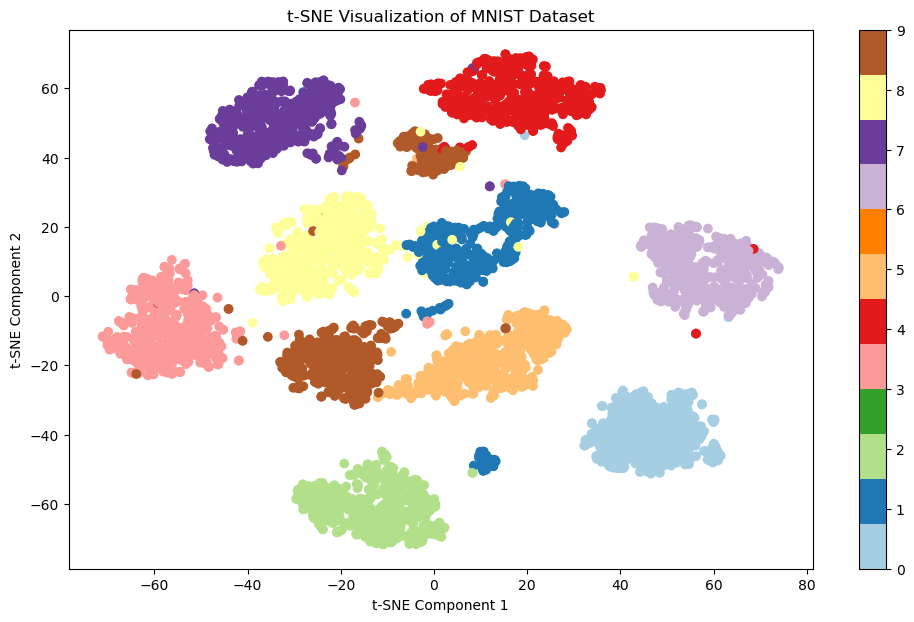

In [43]:
tsne = TSNE(n_components=2, random_state=42)
proj = tsne.fit_transform(X)

plt.figure(figsize=(12, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=y, cmap="Paired")
plt.colorbar(ticks=range(10))
plt.title('t-SNE Visualization of MNIST Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Normalise and reshape the features

We will ***normalise*** the pixel values for each image to range between 0 and 1. We do this by dividing the pixel value by 255, the maximum possible pixel value.
This will help in:
- Faster training and convergence of the optimisation
- This will help the model learn with consistent data, capturing underlying patterns instead of being affected by by the scale of the input features

In [44]:
max_pixel = 16
X = X/max_pixel

Reshape data for CNN

In [45]:
dim_size = 8
batch_size = dim_size * dim_size
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Prepare the train and test splits

In [62]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.24, random_state=42)

X_train = X_train.reshape(-1, 1, dim_size, dim_size)
X_test = X_test.reshape(-1, 1, dim_size, dim_size)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [47]:
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': False} # CPU

train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), shuffle=True, **kwargs)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), shuffle=False, **kwargs)

# Model architecture

Custom CNN Model

In [48]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            # 1st Convolution layer
            torch.nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 2nd Convolution layer
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 3rd Convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),

            # 4th Convolution layer
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # Fully connected
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output of the convolutional layers
        x = self.fc_layers(x) # Pass through the fully connected layers
        # x = x.view(-1, 1, 8, 8)  # Reshape to match the input size
        return x


# Model training

Training function

In [115]:
def evaluate(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batchX, batchY in iter(test_loader):
            features = batchX.to(device)
            labels = batchY.to(device)

            logits = custom_model(features)

            loss = criterion(logits, labels)
            test_loss += loss.item() * features.size(0)

            _, predicted_labels = torch.max(logits, 1)
            _, labels = torch.max(labels, 1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = correct_predictions / total_samples

    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

In [116]:
from sklearn.model_selection import KFold
import numpy as np

def train(model, n_epochs, device, train_loader, optimizer, criterion, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)
    fold_losses = []
    fold_accuracies = []

    for fold, (train_index, val_index) in enumerate(kf.split(train_loader.dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Create dataloaders for this fold
        train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

        train_loader_fold = torch.utils.data.DataLoader(train_loader.dataset, batch_size=train_loader.batch_size, sampler=train_sampler)
        val_loader_fold = torch.utils.data.DataLoader(train_loader.dataset, batch_size=train_loader.batch_size, sampler=val_sampler)

        fold_loss, fold_accuracy = train_fold(model, n_epochs, device, train_loader_fold, val_loader_fold, optimizer, criterion)
        fold_losses.append(fold_loss)
        fold_accuracies.append(fold_accuracy)

    return fold_losses, fold_accuracies

def train_fold(model, n_epochs, device, train_loader, val_loader, optimizer, criterion):
    training_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        start = datetime.now()
        total_elapsed_time = 0.0

        model.train()
        running_loss = 0.0
        
        correct_predictions = 0

        for batchX, batchY in iter(train_loader):
            features = batchX.to(device)
            labels = batchY.to(device)
            
            optimizer.zero_grad()
            logits = model(features)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)

            _, predicted_labels = torch.max(logits, 1)
            _, labels = torch.max(labels, 1)
            correct_predictions += (predicted_labels == labels).sum().item()

        accuracy = correct_predictions / len(train_loader.dataset)
        training_losses.append(running_loss / len(train_loader.dataset))

        val_loss, val_accuracy = evaluate(model, device, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end = datetime.now()
        epoch_elapsed_time = (end - start).total_seconds()

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {training_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, Elapsed Time: {epoch_elapsed_time:.4f} seconds")

    return (training_losses, val_losses), val_accuracies


In [49]:
def train(model, n_epochs, device, train_loader, optimizer, criterion):
    for epoch in range(n_epochs):start = datetime.now()
    total_elapsed_time = 0.0

    training_accuracy = []
    training_loss = []
    accuracy = 0.0

    for epoch in range(n_epochs):
    
        model.train()
        running_loss = 0.0
        
        correct_predictions = 0

        for batchX, batchY in iter(train_loader):
            features = batchX.to(device)
            labels = batchY.to(device)
            
            optimizer.zero_grad()
            logits = model(features)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)

            _, predicted_labels = torch.max(logits, 1)
            _, labels = torch.max(labels, 1)
            correct_predictions += (predicted_labels == labels).sum().item()

        accuracy = correct_predictions / labels.shape[0]
        training_accuracy.append(accuracy)

        epoch_loss = running_loss / len(train_loader.dataset)
        training_loss.append(epoch_loss)

        end = datetime.now()
        epoch_elapsed_time = (end - start).total_seconds()
        total_elapsed_time += epoch_elapsed_time

        print( f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy}, Elapsed tme: {epoch_elapsed_time:.4f}")

    print(f"Total training time: {total_elapsed_time:.4f} seconds")
    
    return training_loss, training_accuracy

Model training parameters

In [117]:
custom_model = CNN().to(device)
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=learning_rate)

n_epochs = 15
losses = []

Run the training

In [118]:
train(custom_model, n_epochs, device, train_loader, optimizer, criterion)

# traing_loss, train_accuracy = train(custom_model, n_epochs, device, train_loader, optimizer, criterion)

Fold 1/5
Test loss: 0.4458
Test accuracy: 0.2632


ValueError: too many values to unpack (expected 2)

In [52]:
plt.plot(traing_loss, label='loss')
plt.xlabel('Epoch')
plt.title('Custom CNN Model Training Loss')
plt.legend()
plt.show()

NameError: name 'traing_loss' is not defined

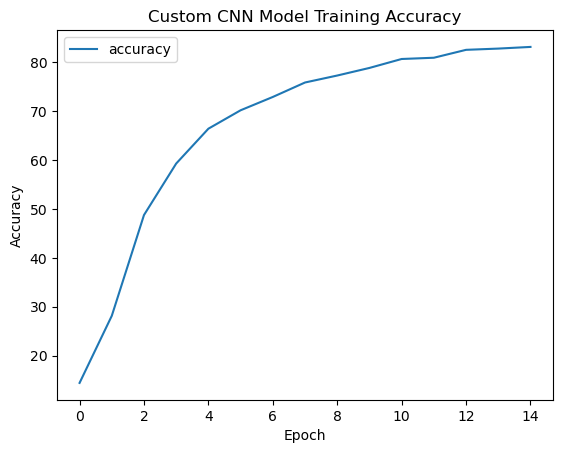

In [ ]:
plt.plot(train_accuracy, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Custom CNN Model Training Accuracy')
plt.legend()
plt.show()

# Model evaluation

Evaluationn function

In [104]:
def evaluate(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batchX, batchY in iter(test_loader):
            features = batchX.to(device)
            labels = batchY.to(device)

            logits = custom_model(features)

            loss = criterion(logits, labels)
            test_loss += loss.item() * features.size(0)

            _, predicted_labels = torch.max(logits, 1)
            _, labels = torch.max(labels, 1)

            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = correct_predictions / total_samples

    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')

    cm = confusion_matrix(all_labels, all_predictions)
    return cm

Evaluate the model

In [105]:
confusion_matrix = evaluate(custom_model, device, test_loader, criterion)

Test loss: 2.3027
Test accuracy: 0.1001


Visualize the confusion matrix

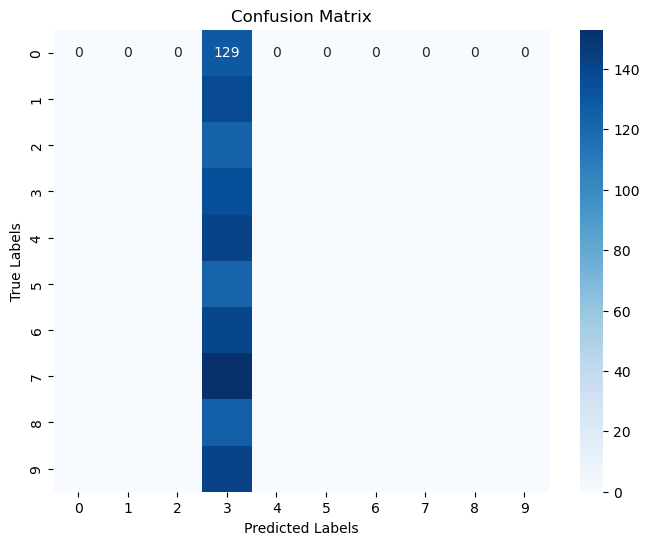

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# Tensorflow and Keras Model for comparative analysis

Keras CNN model

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

X_train = X_train.reshape(-1, 8, 8, 1)
X_test = X_test.reshape(-1, 8, 8, 1)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [89]:
keras_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


Compile the model

In [90]:
keras_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [91]:
history = keras_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/15


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4142 - loss: 1.9823 - val_accuracy: 0.8411 - val_loss: 0.5370
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8552 - loss: 0.4744 - val_accuracy: 0.9416 - val_loss: 0.1954
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9358 - loss: 0.2172 - val_accuracy: 0.9650 - val_loss: 0.1146
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9575 - loss: 0.1359 - val_accuracy: 0.9673 - val_loss: 0.1038
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9519 - loss: 0.1646 - val_accuracy: 0.9720 - val_loss: 0.0824
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9756 - loss: 0.0856 - val_accuracy: 0.9720 - val_loss: 0.0663
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9836 - loss: 0.0644 - val_accuracy: 0.9907 - val_loss: 0.0445
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9739 - loss: 0.0804 - val_accuracy: 0.9813 - val_loss: 0.0391
Epo

Visualise training metrics

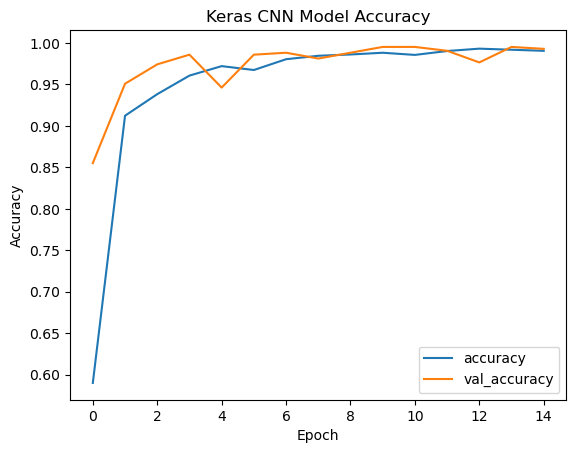

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Keras CNN Model Training Accuracy')
plt.legend()
plt.show()

Evaluate the model

In [97]:
loss, accuracy = keras_model.evaluate(X_test, y_test)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9804 - loss: 0.0678
Loss: 0.0682
Accuracy: 0.9778


Keras Model Training Loss: 0.0682, Keras Model Training Accuracy: 0.9778
